In [15]:
import numpy as np
import pandas as pd
from pymatgen.core.composition import Composition

import torch
import torch.nn as nn
import os
import re
import json
import pytorch_lightning as L
import wandb

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR, StepLR
from torch.nn import CrossEntropyLoss, L1Loss, MSELoss, ReLU, NLLLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from roost.Data import data_from_composition_general
from roost.Model import Roost
from roost.utils import count_parameters, Scaler, DummyScaler, BCEWithLogitsLoss, Lamb, Lookahead, get_compute_device

from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

data_type_np = np.float32
data_type_torch = torch.float32
device=get_compute_device()
device='cpu'


class RoostDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str, 
                 batch_size = 256,
                 features='onehot'):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.features=features

    def prepare_data(self):
        path='data/el-embeddings/'
        if(self.features == 'onehot'):
            with open(path+'onehot-embedding.json',"r") as f:
                elem_features=json.load(f)
        
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_dataset = data_from_composition_general(self.data_train,elem_features)
        self.train_len = len(self.train_dataset)
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_dataset = data_from_composition_general(self.data_val,elem_features)
        self.val_len = len(self.val_dataset)

        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_dataset = data_from_composition_general(self.data_test,elem_features)
        self.test_len = len(self.test_dataset)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len, shuffle=False)
    
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len, shuffle=False)
    

class RoostLightningClass(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.batch_size=config['data_params']['batch_size']
        self.out_dims=config['model_params']['output_dim']
        self.n_graphs=config['model_params']['n_graphs']
        self.comp_heads=config['model_params']['comp_heads']
        self.internal_elem_dim=config['model_params']['internal_elem_dim']
        self.setup=config['setup_params']
        self.model = Roost(**config['model_params'])
        # maybe need to do it, to unify Roost and CrabNet
        print('\n Model architecture: out_dims, n_graphs, heads, internal_elem_dim')
        print(f'{self.out_dims}, {self.n_graphs}, '
                  f'{self.comp_heads}, {self.internal_elem_dim}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')
        
        if(config['setup_params']['loss'] == 'BCEWithLogitsLoss'):
            self.criterion = BCEWithLogitsLoss

        if(re.search('.json', config['data_params']['train_path'] )):
            train_data=pd.read_json(config['data_params']['train_path'])
        elif(re.search('.csv', config['data_params']['train_path'])):
            train_data=pd.read_csv(config['data_params']['train_path'])
        y=train_data['disorder'].values
        self.step_size = len(y)
        if(np.sum(y)>0):
            self.weight=torch.tensor(((len(y)-np.sum(y))/np.sum(y)),dtype=data_type_torch).to(device)   

    def forward(self, batch):
        out = self.model(batch.x, batch.edge_index, batch.pos, batch.batch)
        return out

    def configure_optimizers(self):
        if(self.setup['optim'] == 'AdamW'):
        # We use AdamW optimizer with MultistepLR scheduler as in the original Roost model
            optimizer = torch.optim.AdamW(self.parameters(),lr=self.setup['learning_rate'], 
                                        weight_decay=self.setup['weight_decay']) 
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.3)

        elif(self.setup['optim'] == 'Lamb'):
            base_optim = Lamb(params=self.model.parameters(),lr=0.001)
            optimizer = Lookahead(base_optimizer=base_optim)
            scheduler = CyclicLR(optimizer,
                                base_lr=self.setup['base_lr'],
                                max_lr=self.setup['max_lr'],
                                cycle_momentum=False,
                                step_size_up=self.step_size)

        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        mc=matthews_corrcoef(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("train_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("train_mc", mc, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        mc=matthews_corrcoef(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("val_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("val_mc", mc, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss
    
    def test_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        mc=matthews_corrcoef(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("test_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("test_mc", mc, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits=self(batch)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        
        return batch.y.view(-1).detach().cpu().numpy(), prediction, y_pred

In [8]:
data_file = 'data/general_disorder.csv'
df=pd.read_csv(data_file,usecols=['formula', 'disorder'])
index=np.linspace(0,len(df)-1,len(df),dtype=int)
train_idx,test_idx= train_test_split(index, test_size=0.2, random_state=42)
train_idx,val_idx= train_test_split(train_idx, test_size=0.1, random_state=42)
val_set = df.iloc[val_idx]
val_set.to_csv('data/roost_data/val.csv',index=False)
test_set = df.iloc[test_idx]
test_set.to_csv('data/roost_data/test.csv',index=False)
train_set = df.iloc[train_idx]
train_set.to_csv('data/roost_data/train.csv',index=False)

In [9]:
path='data/el-embeddings/'
with open(path+'onehot-embedding.json',"r") as f:
    elem_features=json.load(f)
elem_emb_len=len(elem_features['H'])

with open('roost/roost_config.json','r') as f:
    config=json.load(f)

config['model_params']['input_dim']=elem_emb_len

In [10]:
class RoostDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str, 
                 batch_size = 256,
                 features='onehot'):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.features=features

    def prepare_data(self):
        path='data/el-embeddings/'
        if(self.features == 'onehot'):
            with open(path+'onehot-embedding.json',"r") as f:
                elem_features=json.load(f)
        
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_dataset = data_from_composition_general(self.data_train,elem_features)
        self.train_len = len(self.train_dataset)
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_dataset = data_from_composition_general(self.data_val,elem_features)
        self.val_len = len(self.val_dataset)

        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_dataset = data_from_composition_general(self.data_test,elem_features)
        self.test_len = len(self.test_dataset)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len, shuffle=False)
    
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len, shuffle=False)


In [11]:
class RoostLightningClass(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.batch_size=config['data_params']['batch_size']
        self.out_dims=config['model_params']['output_dim']
        self.n_graphs=config['model_params']['n_graphs']
        self.comp_heads=config['model_params']['comp_heads']
        self.internal_elem_dim=config['model_params']['internal_elem_dim']
        self.model = Roost(**config['model_params'])
        # maybe need to do it, to unify Roost and CrabNet
        print('\n Model architecture: out_dims, n_graphs, heads, internal_elem_dim')
        print(f'{self.out_dims}, {self.n_graphs}, '
                  f'{self.comp_heads}, {self.internal_elem_dim}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')
        
        if(config['setup_params']['loss'] == 'BCEWithLogitsLoss'):
            self.criterion = config['setup_params']['loss']
            
        self.base_lr=config['setup_params']['base_lr']
        self.max_lr=config['setup_params']['max_lr']

        if(re.search('.json', config['data_params']['train_path'] )):
            train_data=pd.read_json(config['data_params']['train_path'])
        elif(re.search('.csv', config['data_params']['train_path'])):
            train_data=pd.read_csv(config['data_params']['train_path'])
        y=train_data['disorder'].values
        self.step_size = len(y)
        if(np.sum(y)>0):
            self.weight=torch.tensor(((len(y)-np.sum(y))/np.sum(y)),dtype=data_type_torch).to(device)    
    
    def forward(self, batch):
        out = self.model(batch.x, batch.edge_index, batch.pos, batch.batch)
        return out

    # def configure_optimizers(self):
    #     # We use AdamW optimizer with MultistepLR scheduler as in the original Roost model
    #     optimizer = torch.optim.AdamW(self.parameters(),lr=config['setup_params']['learning_rate'], 
    #                                   weight_decay=config['setup_params']['weight_decay']) 
    #     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.3)
    #     return [optimizer], [scheduler]
    
    def configure_optimizers(self):
        base_optim = Lamb(params=self.model.parameters(),lr=0.001)
        optimizer = Lookahead(base_optimizer=base_optim)
        lr_scheduler = CyclicLR(optimizer,
                                base_lr=self.base_lr,
                                max_lr=self.max_lr,
                                cycle_momentum=False,
                                step_size_up=self.step_size)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=3,
        #                     gamma=0.5)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("train_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("val_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        logits=self(batch)
        loss=self.criterion(logits, batch.y,self.weight)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        acc=balanced_accuracy_score(y_pred,batch.y.view(-1).detach().cpu().numpy())
        f1=f1_score(y_pred,batch.y.view(-1).detach().cpu().numpy())

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        self.log("test_f1", f1, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits=self(batch)
        prediction = torch.sigmoid(logits)
        y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
        
        return prediction, y_pred

In [12]:
L.seed_everything(42)
# sets seeds for numpy, torch and python.random.
model = RoostLightningClass(**config)
trainer = Trainer(devices=1, accelerator="cpu",max_epochs=1, 
                  callbacks=[StochasticWeightAveraging(swa_epoch_start=config['setup_params']['swa_epoch_start'],swa_lrs=config['setup_params']['swa_lrs']),
                             ModelCheckpoint(monitor='val_acc', mode='max',dirpath='roost_models/trained_models/', filename='disorder-{epoch:02d}-{val_acc:.2f}'),
                             EarlyStopping(monitor='val_acc', mode='max', patience=3)])

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 2, 3, 64
Model size: 2124817 parameters



/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [13]:
disorder_data = RoostDataModule(config['data_params']['train_path'],
                                   config['data_params']['val_path'],
                                   config['data_params']['test_path'])

In [14]:
trainer.fit(model, datamodule=disorder_data)

Missing logger folder: /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/lightning_logs
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models exists and is not empty.

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Roost | 2.1 M  | train
----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.499     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


TypeError: 'str' object is not callable

In [21]:
trainer.predict(ckpt_path='best', datamodule=disorder_data)

Restoring states from the checkpoint path at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.67.ckpt
Loaded model weights from the checkpoint at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.67.ckpt
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[(tensor([0.7166, 0.5225, 0.6929,  ..., 0.8062, 0.7246, 0.7388]),
  array([ True,  True,  True, ...,  True,  True,  True]))]

In [ ]:
# print('Start sweeping with different parameters for RF...')

    # wandb.login(key='b11d318e434d456c201ef1d3c86a3c1ce31b98d7')

    # sweep_config = {
    # 'method': 'random',
    # 'parameters': {'n_estimators': {'values': [50, 100, 150, 200]},
    #                'class_weight': {'values':['balanced', 'balanced_subsample']},
    #                'criterion': {'values': ['gini', 'entropy', 'log_loss']}
    # }
    # }

    # sweep_id = wandb.sweep(sweep=sweep_config, project="RF-disorder-prediction-global-disorder")

    # wandb.agent(sweep_id, function=main, count=10)

    # wandb.finish()

In [ ]:
sweep_config = {
    'method': 'random',
    'parameters': {'n_estimators': {'values': [50, 100, 150, 200]},
                   'class_weight': {'values':['balanced', 'balanced_subsample']},
                   'criterion': {'values': ['gini', 'entropy', 'log_loss']}
    }
    }

In [6]:
config

{'seed': 42,
 'model_name': 'roost',
 'epochs': 50,
 'patience': 10,
 'test_size': 0.2,
 'val_size': 0.1,
 'train': True,
 'evaluate': True,
 'classification': True,
 'data_params': {'batch_size': 1024,
  'pin_memory': False,
  'shuffle': True,
  'data_seed': 0,
  'train_path': 'data/roost_data/train.csv',
  'val_path': 'data/roost_data/val.csv',
  'test_path': 'data/roost_data/test.csv'},
 'setup_params': {'optim': 'AdamW',
  'learning_rate': 0.0005,
  'weight_decay': 1e-06,
  'momentum': 0.9,
  'loss': 'BCEWithLogitsLoss',
  'base_lr': 0.0001,
  'max_lr': 0.006,
  'swa_epoch_start': 0.05,
  'swa_lrs': 0.01},
 'model_params': {'input_dim': 112,
  'output_dim': 1,
  'hidden_layer_dims': [1024, 512, 256, 64],
  'n_graphs': 2,
  'elem_heads': 3,
  'internal_elem_dim': 64,
  'g_elem_dim': 256,
  'f_elem_dim': 256,
  'comp_heads': 3,
  'g_comp_dim': 256,
  'f_comp_dim': 256,
  'batchnorm': False,
  'negative_slope': 0.2}}

In [16]:
L.seed_everything(config['seed'])

data_file = 'data/general_disorder.csv'
df=pd.read_csv(data_file,usecols=['formula', 'disorder'])
index=np.linspace(0,len(df)-1,len(df),dtype=int)
train_idx,test_idx= train_test_split(index, test_size=0.2, random_state=config['seed'])
train_idx,val_idx= train_test_split(train_idx, test_size=0.1, random_state=config['seed'])
val_set = df.iloc[val_idx]
val_set.to_csv('data/roost_data/val.csv',index=False)
test_set = df.iloc[test_idx]
test_set.to_csv('data/roost_data/test.csv',index=False)
train_set = df.iloc[train_idx]
train_set.to_csv('data/roost_data/train.csv',index=False)
    
wandb_logger = WandbLogger(project="Roost-global-disorder", config=config, log_model="all")
model = RoostLightningClass(**config)
trainer = Trainer(devices=1, accelerator=device,max_epochs=1, logger=wandb_logger, 
                  callbacks=[StochasticWeightAveraging(swa_epoch_start=config['setup_params']['swa_epoch_start'],swa_lrs=config['setup_params']['swa_lrs']),
                             ModelCheckpoint(monitor='val_acc', mode='max',dirpath='roost_models/trained_models/', filename='disorder-{epoch:02d}-{val_acc:.2f}'),
                             EarlyStopping(monitor='val_acc', mode='max', patience=config['patience'])])
disorder_data = RoostDataModule(config['data_params']['train_path'],
                                   config['data_params']['val_path'],
                                   config['data_params']['test_path'])
trainer.fit(model, datamodule=disorder_data)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 2, 3, 64
Model size: 2124817 parameters



wandb: Currently logged in as: epat. Use `wandb login --relogin` to force relogin


/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models exists and is not empty.

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | Roost | 2.1 M  | train
----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.499     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be 

Training: |          | 0/? [00:00<?, ?it/s]

Swapping scheduler `MultiStepLR` for `SWALR`
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elenapatyukova/anaconda3/envs/di

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
y_true, prediction, y_pred=trainer.predict(ckpt_path='best', datamodule=disorder_data)
metrics={}
metrics['acc']=balanced_accuracy_score(y_true,y_pred)
metrics['f1']=f1_score(y_true,y_pred)
metrics['precision']=precision_score(y_true,y_pred)
metrics['recall']=recall_score(y_true,y_pred)
metrics['mc']=matthews_corrcoef(y_true,y_pred)
metrics['roc_auc']=roc_auc_score(y_true,prediction)
pred_matrix=np.array([y_true, prediction, y_pred])

Restoring states from the checkpoint path at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.73-v1.ckpt
Loaded model weights from the checkpoint at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.73-v1.ckpt
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 3, got 1)

In [28]:
y_true, prediction, y_pred=trainer.predict(ckpt_path='best', datamodule=disorder_data)[0]

Restoring states from the checkpoint path at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.73-v1.ckpt
Loaded model weights from the checkpoint at /Users/elenapatyukova/Documents/GitHub/Disorder-prediction-new/roost_models/trained_models/disorder-epoch=00-val_acc=0.73-v1.ckpt
/Users/elenapatyukova/anaconda3/envs/disorder_pred/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [34]:
y_true.astype(bool)

array([ True,  True, False, ...,  True,  True,  True])

In [35]:
y_pred


array([ True,  True, False, ...,  True, False,  True])

In [58]:
y_pred_1=prediction>0.5

In [59]:
y_pred_1

tensor([ True,  True, False,  ...,  True, False,  True])

In [60]:
balanced_accuracy_score(y_true,y_pred),f1_score(y_true,y_pred),matthews_corrcoef(y_true,y_pred)

(0.7291196220208225, 0.7806778027626085, 0.4560485623887267)

In [61]:
balanced_accuracy_score(y_true,y_pred_1),f1_score(y_true,y_pred_1),matthews_corrcoef(y_true,y_pred_1)

(0.7291196220208225, 0.7806778027626085, 0.4560485623887267)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [36]:
np.sum(y_true)/len(y_true)

0.6029052207680138

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [40]:
import sklearn
import matplotlib.pyplot as plt

In [41]:
x=sklearn.metrics.roc_curve(y_true, prediction)

fpr
ndarray of shape (>2,)
Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].

tpr
ndarray of shape (>2,)
Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].

thresholds
ndarray of shape (n_thresholds,)
Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to np.inf

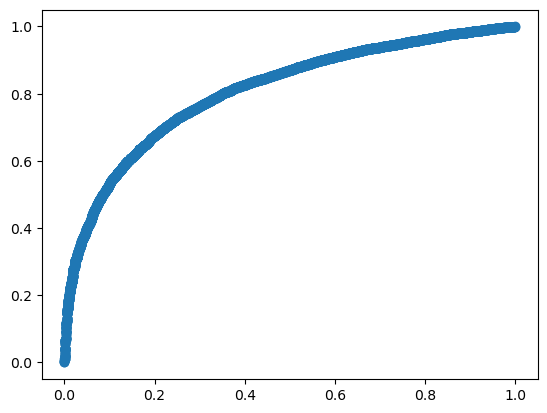

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [43]:
plt.scatter(x[0],x[1])